# Projet M1 

#### Initialisation et dépendances 
Charge les bibliothèques nécessaires.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function (lines) { return false ; }

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as sw
import math
from scipy import signal
from scipy.signal import butter, lfilter
from operator import add


# Fichier audio

Cette section contient l'étude du fichier audio chargé. Vous pourrez y trouver son spectre d'amplitude ainsi que son spectrogramme.

Vous pouvez configurer la source du fichier audio dans la cellule ci-dessous.

In [3]:
# Source
file = "src/test2.wav"

#### Spectre d'amplitude

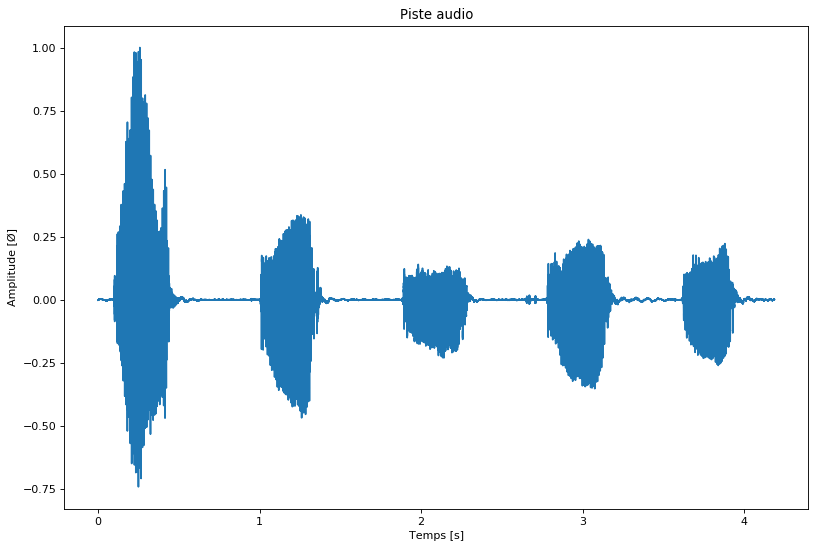

In [4]:
# Lecture du fichier audio
fs, y = sw.read(file)
# y = np.array(y, dtype=float)
yn = y/max(y)

# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

# Affichage du spectre d'amplitude
plt.figure(figsize=(12, 8), dpi= 80, facecolor="w", edgecolor="k")
plt.title("Piste audio")
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude [Ø]")
plt.plot(t, yn)
plt.show()

#### Spectrogramme

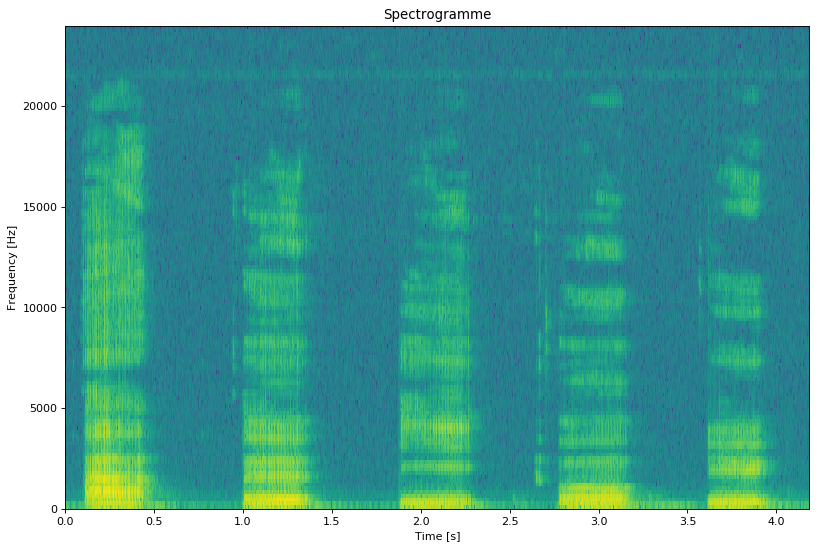

In [5]:
# Affichage du spectrogramme
plt.figure(figsize=(12, 8), dpi= 80, facecolor="w", edgecolor="k")
plt.title("Spectrogramme")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.specgram(y, Fs=fs)
plt.show()

# Banque de filtres

In [6]:
# Ordre des filtres
n = 3
# Facteur de qualité
q = 3
# Nombre de filtres
nb_filters = 16
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000
# Valeur de saturation de la puissance de densité spectrale 
psd_max = 10
# Seuil de puissance de densité spectrale pour être considérer actif
psd_treshold = 7
# Résolution temporelle des spectrogramme (entre 0 et 1)
time_res = 1.00

#### Passe-bande (butterworth)
La fonction ci-dessous permet de générer un filtre passe-bande analogique.
* fc : Fréquence centrale
* q : Facteur de qualité
* n : Ordre du filtre

In [7]:
def bandpass(fc, q, n, fs):
    # Calcul de la bande passante grâce au facteur de qualité
    df = fc / q
    # Calcul de la fréquence de Nyquist
    nyq = fs / 2
    # Détermination des fréquences de coupures basses et hautes
    fl = (fc - df/2)
    fh = (fc + df/2)
    # Création du filtre de butterworth    
    return butter(N=n, Wn=[fl/nyq, fh/nyq], btype="band"), fc, fl, fh

#### Génération de la banque de filtres

In [8]:
# Banque des filtres
filters = []
filters_fq = []
# Calcul du pas
step = round((fmax-fmin)/nb_filters)
# Génération des filtres
for fc in range(fmin, fmax, step):
    bp, fc, fl, fh = bandpass(fc, q, n, fs)
    filters.append(bp)
    filters_fq.append({"fc":fc, "fl":fl, "fh":fh})

#### Réponse fréquentielle de la banque de filtres

C:\ProgramUser\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


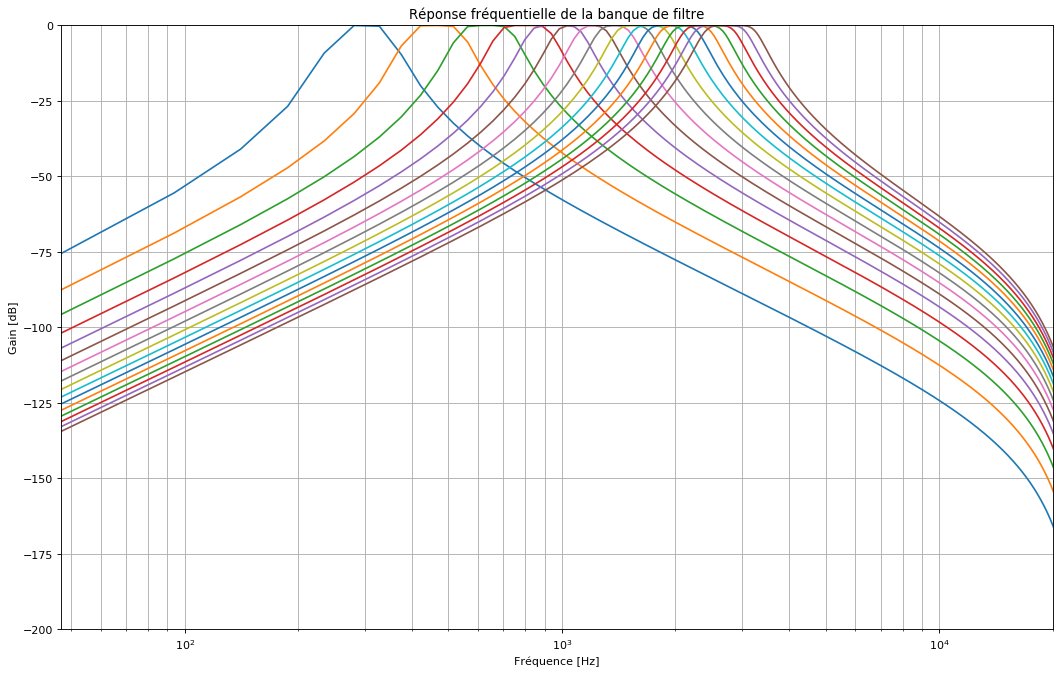

In [9]:
# Préparation de l'affichage
plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")

# Affichage des filtres
for i in range(len(filters)):
    # Calcul de la réponse fréquentielle du filtre
    b, a = filters[i]
    w, h = signal.freqz(b, a)
    # Affichage
    plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

# Données d'affichage
plt.title("Réponse fréquentielle de la banque de filtre")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Gain [dB]")
plt.xlim(0, 20000)
plt.ylim(-200, 0)
plt.grid(which="both", axis="both")
plt.show()

#### Application de la banque de filtres

In [10]:
# Signaux filtrés
filtered = []
filtered.append(y)
t = np.linspace(0, N/fs, N)
# Application de la banque de filtres
for i in range(len(filters)):
    # Calcul de la réponse
    b, a = filters[i]
    filtered.append(lfilter(b, a, y))

In [20]:
# Etats des filtres
states = []
states_sequences = [] 
def state_at(s, filter_no):
    # Calcul de l'indice dans la séquence
    i = 0
    while (i < len(states_sequences)) and (states_sequences[i] < s):
        i = i+1
    # Retourne l'état du filtre au temps spécifié
    return states[filter_no][i]

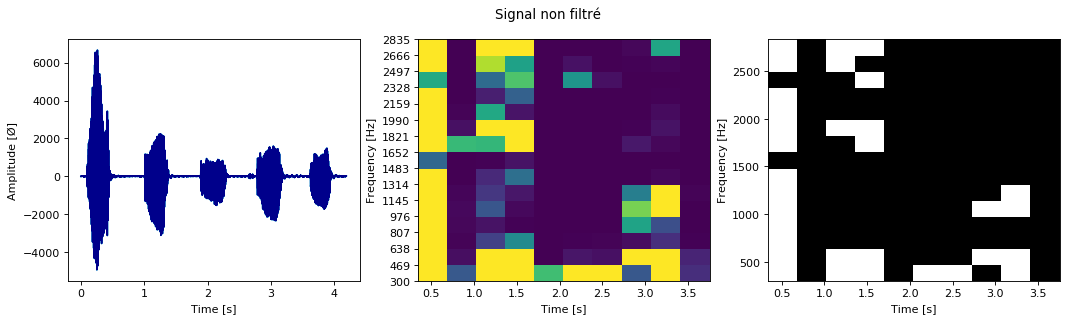

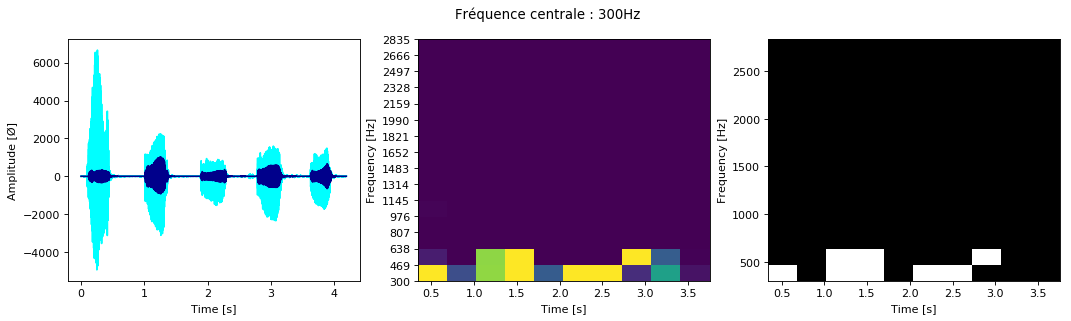

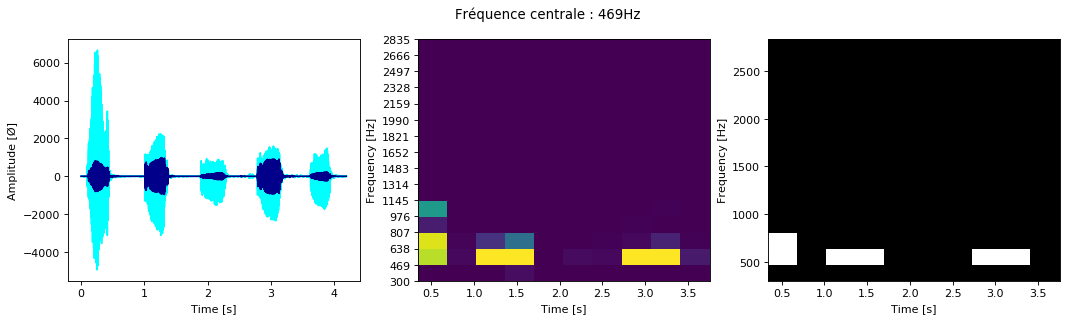

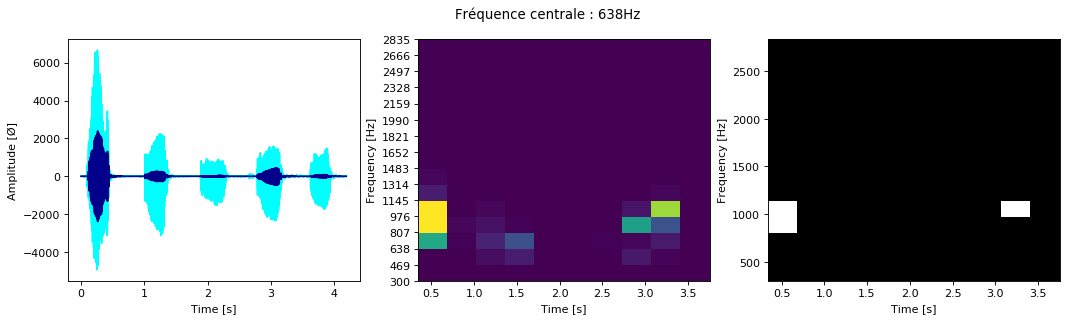

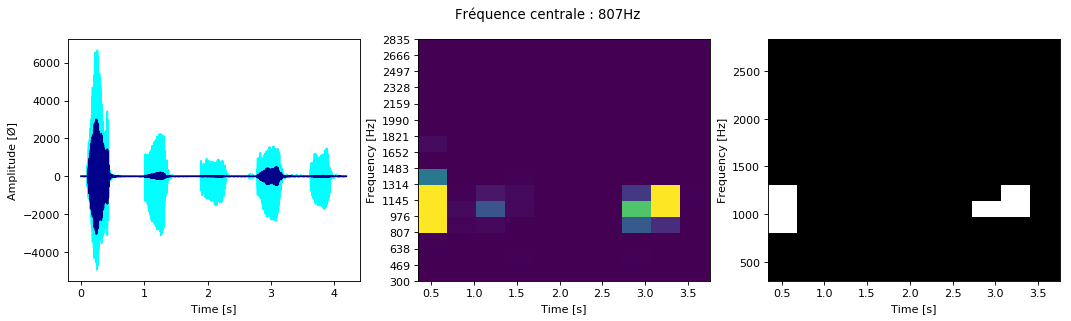

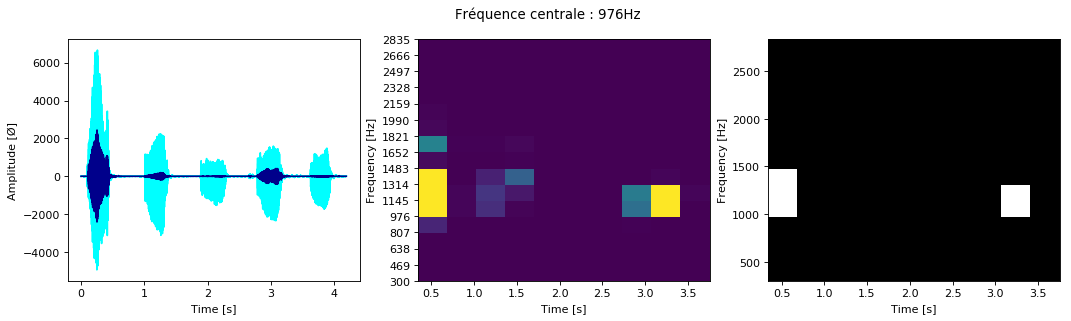

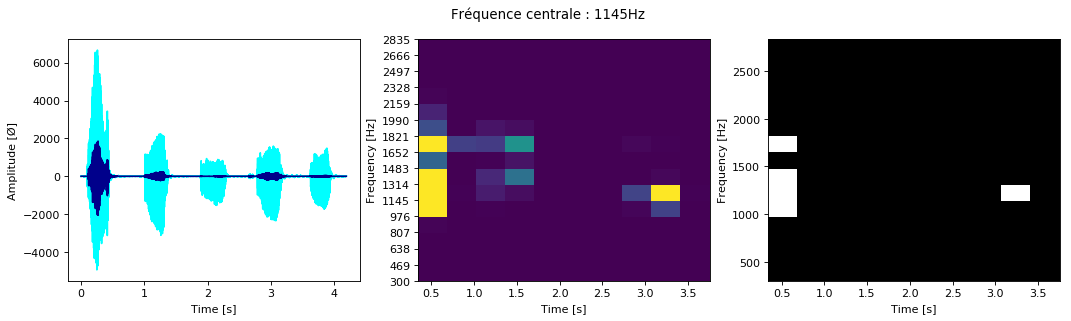

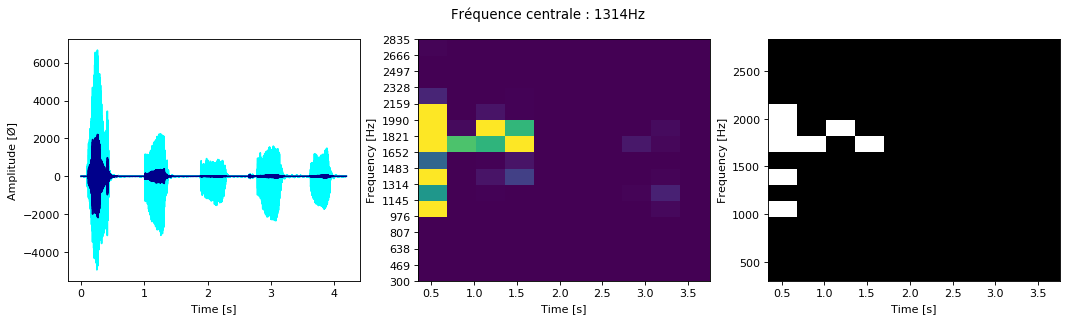

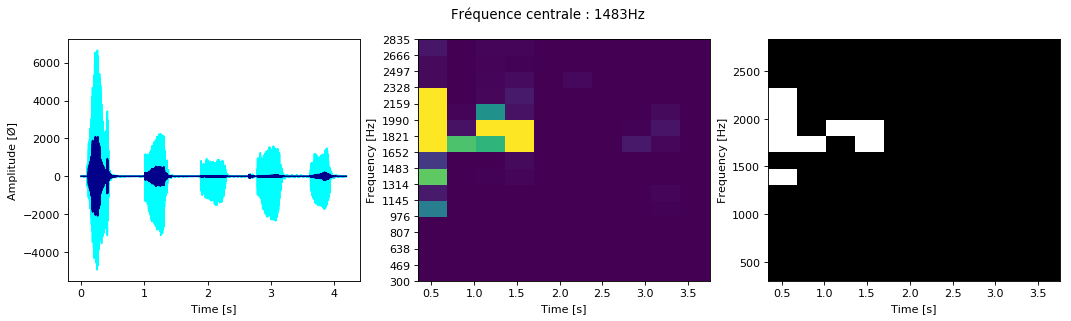

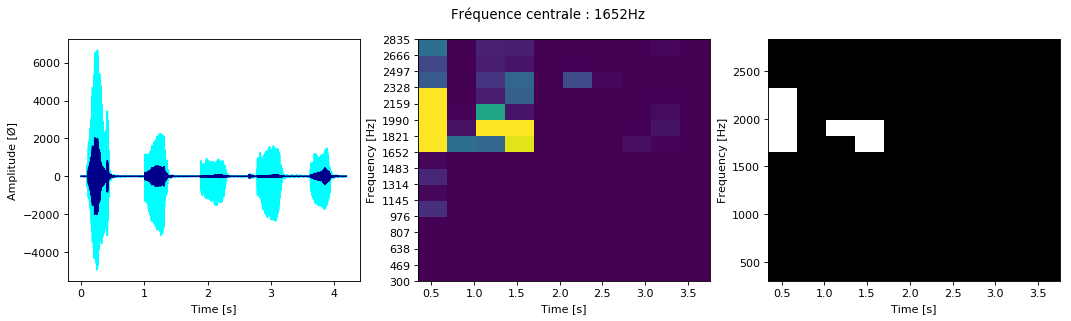

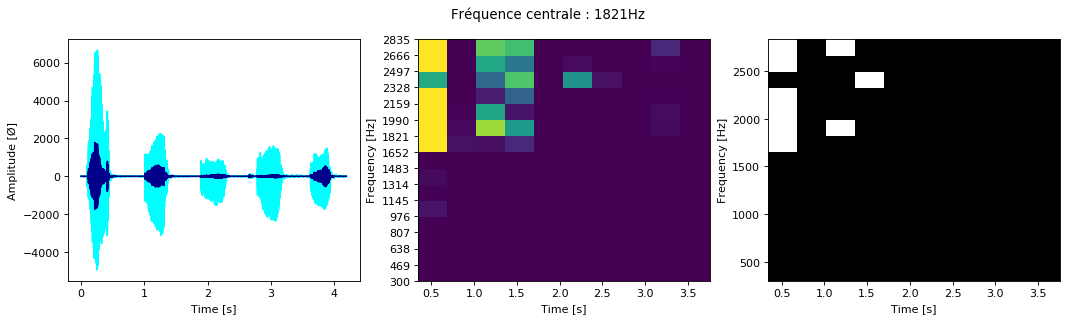

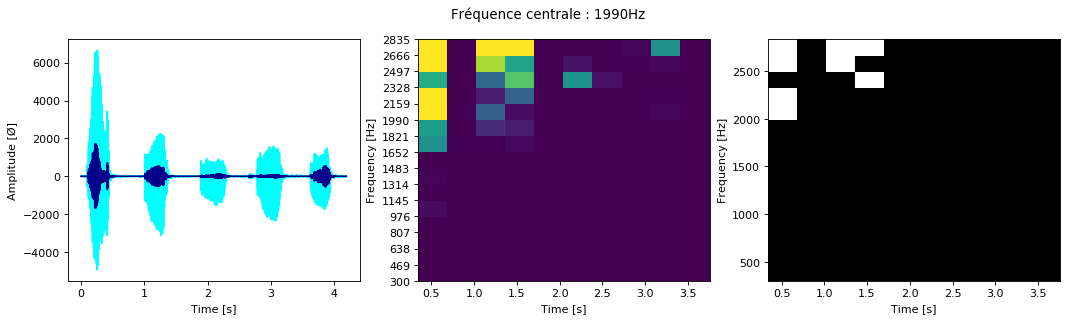

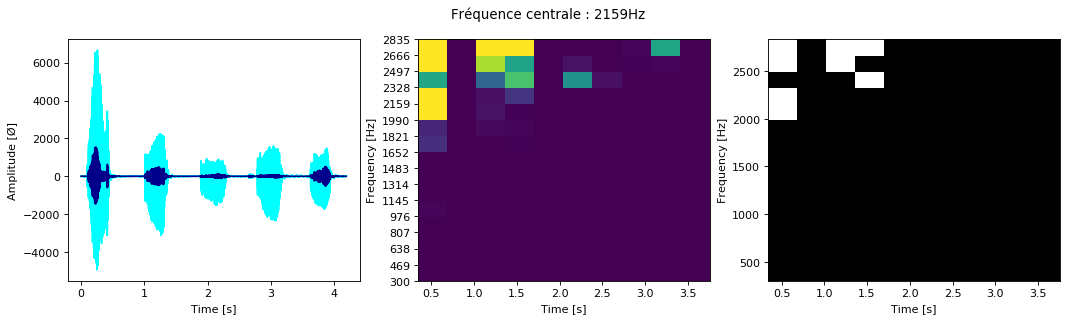

In [ ]:
# Affichage des signaux filtrés
for i in range(len(filtered)):
    # Préparation des figures
    f, ax = plt.subplots(1, 3, figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    f.suptitle("Signal non filtré" if i == 0 else "Fréquence centrale : "+str(filters_fq[i-1]["fc"])+"Hz")
    # Affichage du spectre d'amplitude
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Amplitude [Ø]")
    ax[0].plot(t, y, color="aqua")
    ax[0].plot(t, filtered[i], color="darkblue")
    
    # Préparation du spectrogramme
    NFFT = 2**int(math.log(fs, 2))
    spectrum, freqs, time, img = ax[1].specgram(filtered[i], Fs=fs, NFFT=NFFT, noverlap=time_res*(NFFT/2))
    ax[1].cla()
    ax[1].set_ylabel("Frequency [Hz]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_yticks(np.arange(fmin, fmax, step))
    
    # Traitement des données spectrogramme
    rspectrum = []; rfreqs = [];
    for j in range(len(filters_fq)):
        # Récupération des index des fréquences centrales, basses et hautes
        fc = np.argmin(np.abs(freqs - filters_fq[j]["fc"]))
        fl = np.argmin(np.abs(freqs - filters_fq[j]["fl"]))
        fh = np.argmin(np.abs(freqs - filters_fq[j]["fh"]))
        # Somme des valeurs entre la fréquence de coupure basse et haute
        summed = spectrum[fl]
        for k in range(fl+1, fh):
            map(add, summed, spectrum[k])
        # Ajout des données
        rspectrum.append(np.clip(summed, 0, psd_max))
        rfreqs.append(freqs[fc])
    # Affichage du spectrogramme
    ax[1].pcolormesh(time, rfreqs, rspectrum)
    ax[1].plot()
    
    # Traitement de états
    for j in range(len(rspectrum)):
        for k in range(len(rspectrum[j])):
            rspectrum[j][k] = rspectrum[j][k] > psd_treshold
            
    # Affichage des différents états
    ax[2].pcolormesh(time, rfreqs, rspectrum, cmap=colors.ListedColormap(["black","white"]))
    ax[2].plot()
    ax[2].set_ylabel("Frequency [Hz]")
    ax[2].set_xlabel("Time [s]")
    
    # Ajout des données pour la fonction d'état
    states.append(np.transpose(rspectrum))
    states_sequences = time
    
    # Affichage
    plt.show()